In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_parquet('E:/Phat/imbalance/data_electricity_processing.parquet')

In [4]:
print("No Frauds:", round((df['fraud'].value_counts()[0]/len(df)) *100,2), "%")
print("Frauds:", round((df['fraud'].value_counts()[1]/len(df)) *100,2), "%")

No Frauds: 98.73 %
Frauds: 1.27 %


In [20]:
missing_value_cols = ['ma_ttcto', 'so_cot', 'so_hop', 'ngay_hhluc_vitri_ddo', 
                      'ngay_hhluc_khang','ngay_hhluc_diemdo', 'ngay_hhluc']
for col in missing_value_cols:
    df[col].fillna("Missing", inplace=True)

In [21]:
numerical_cols = ['id_chiso','id_bcs','hs_nhan','so_cto_chiso','ky','thang','nam',
                  'chiso_cu','chiso_moi','san_luong','sluong_ttiep','sluong_trphu',
                   'thd_le','sluong_1','sluong_2','sluong_3','ma_cto','so_cto_hso_cto',
                    'ma_cloai','so_pha','id_khang','id_ddo','kimua_cspk','csuat','so_cto_csuat_ddo',
                     'thang_csuat_ddo','gia_tri' ]

scaler = StandardScaler()
for col in numerical_cols:
    df[col] = scaler.fit_transform(df[[col]])

In [22]:
cat_cols = ['ma_dviqly','ma_dvictren','ma_ddo','bcs_chiso','loai_chiso',
            'ma_ttcto','ngay_dky','ngay_cky','ngay_tao_chiso','nguoi_tao_chiso',
            'ngay_sua_chiso','nguoi_sua_chiso','ma_cnang_chiso','so_cot','so_hop',
            'ma_tram','ngay_hluc_vitri_ddo','ngay_hhluc_vitri_ddo','ngay_bdong',
            'ngay_kdinh','ma_bdong','dong_dien','dien_ap','vh_cong','ten_khang',
            'ma_khang','ngay_hluc_khang','ngay_hhluc_khang','dia_chi','ngay_hluc_diem_do',
            'ngay_hhluc_diemdo','loai_giatri','ngay_hluc','ngay_hhluc']

oe = OrdinalEncoder()
for col in cat_cols:
    df[col] = oe.fit_transform(df[[col]].astype(str)).astype(int)

### Split data in Train, Test and Validation

In [ ]:
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang',
    'ngay_hhluc_vitri_ddo', 
    'ngay_hhluc_khang',
    'ngay_hhluc_diemdo',
    'ngay_hhluc',
    'id_bcs',
    'ngay_kdinh',
    'loai_chiso'
]

X = df.drop(columns=cols_to_drop)
y = df['fraud']

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Decision tree

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tao custom metrix
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Tạo custom transformer để thực hiện oversampling và undersampling
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, oversampler, undersampler):
        self.oversampler = oversampler
        self.undersampler = undersampler

    def fit(self, X, y):
        # Không cần fit gì ở đây, chỉ cần trả về chính X, y
        return self

    def transform(self, X, y=None):
        # Áp dụng oversampling rồi đến undersampling nếu y không phải None
        if y is not None:
            X_res, y_res = self.oversampler.fit_resample(X, y)
            X_res, y_res = self.undersampler.fit_resample(X_res, y_res)
            return X_res, y_res
        return X  # Nếu y là None, chỉ trả về X


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

SEED = 42

# Chuẩn bị dữ liệu
X = X_train
y = y_train

# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Khởi tạo mô hình Decision Tree
model = DecisionTreeClassifier(
    criterion='gini',        # Hoặc 'entropy'
    max_depth=6,             # Giới hạn độ sâu của cây
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=SEED
)

# Khởi tạo các phương pháp resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

# Tạo pipeline hoàn chỉnh sử dụng custom transformer
full_pipeline = Pipeline([
    ('resample', ResampleTransformer(oversampler, undersampler)),
    ('model', model)
])

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
full_pipeline.fit(X, y)


Performing cross-validation with Augmentation...
Cross-validation pAUC scores: [0.19546301 0.19550727 0.19548559 0.19543177 0.19556264]
Mean pAUC: 0.1955, Std: 0.0000
Training final model on the entire combined dataset...


Pipeline(steps=[('resample',
                 ResampleTransformer(oversampler=RandomOverSampler(random_state=42,
                                                                   sampling_strategy=0.03),
                                     undersampler=RandomUnderSampler(random_state=42,
                                                                     sampling_strategy=0.03))),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=5,
                                        min_samples_split=10,
                                        random_state=42))])

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   3127192
           1       1.00      0.98      0.99    907808

    accuracy                           0.99   4035000
   macro avg       1.00      0.99      0.99   4035000
weighted avg       0.99      0.99      0.99   4035000



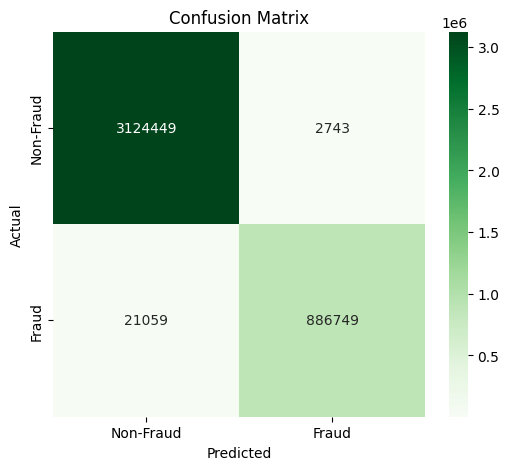

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

Custom pAUC Score: 0.19552637346034896
AUC Score: 0.9955263734603489


In [14]:
# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)
# In kết quả 
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')


AUC Score: 0.9955263734603489


Text(0, 0.5, 'True Positive Rate')

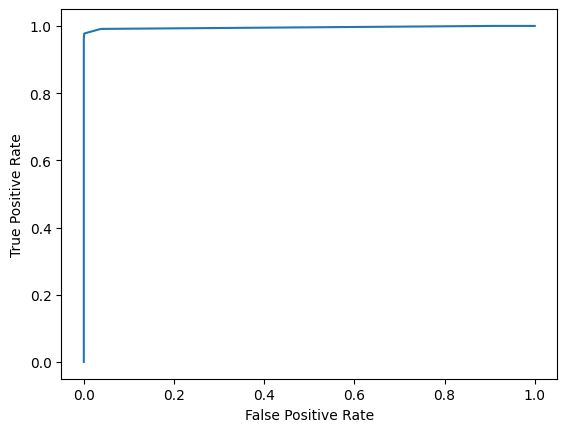

In [15]:
# Ve ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
Features = [col for col in df.columns if col not in cols_to_drop]
print(Features)

['ma_dviqly', 'id_chiso', 'id_bcs', 'ma_dvictren', 'ma_ddo', 'bcs_chiso', 'hs_nhan', 'so_cto_chiso', 'ky', 'thang', 'nam', 'chiso_cu', 'chiso_moi', 'san_luong', 'sluong_ttiep', 'sluong_trphu', 'loai_chiso', 'thd_le', 'ma_ttcto', 'ngay_dky', 'ngay_cky', 'sluong_1', 'sluong_2', 'sluong_3', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso', 'nguoi_sua_chiso', 'ma_cnang_chiso', 'so_cot', 'so_hop', 'ma_tram', 'ngay_hluc_vitri_ddo', 'ngay_hhluc_vitri_ddo', 'ma_cto', 'so_cto_hso_cto', 'ngay_bdong', 'ngay_kdinh', 'ma_bdong', 'dong_dien', 'dien_ap', 'vh_cong', 'ma_cloai', 'so_pha', 'id_khang', 'ten_khang', 'ma_khang', 'ngay_hluc_khang', 'ngay_hhluc_khang', 'dia_chi', 'ngay_hluc_diem_do', 'ngay_hhluc_diemdo', 'id_ddo', 'kimua_cspk', 'csuat', 'so_cto_csuat_ddo', 'thang_csuat_ddo', 'loai_giatri', 'gia_tri', 'ngay_hluc', 'ngay_hhluc']


C:\Users\HOME\AppData\Local\Temp\ipykernel_10164\514820566.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


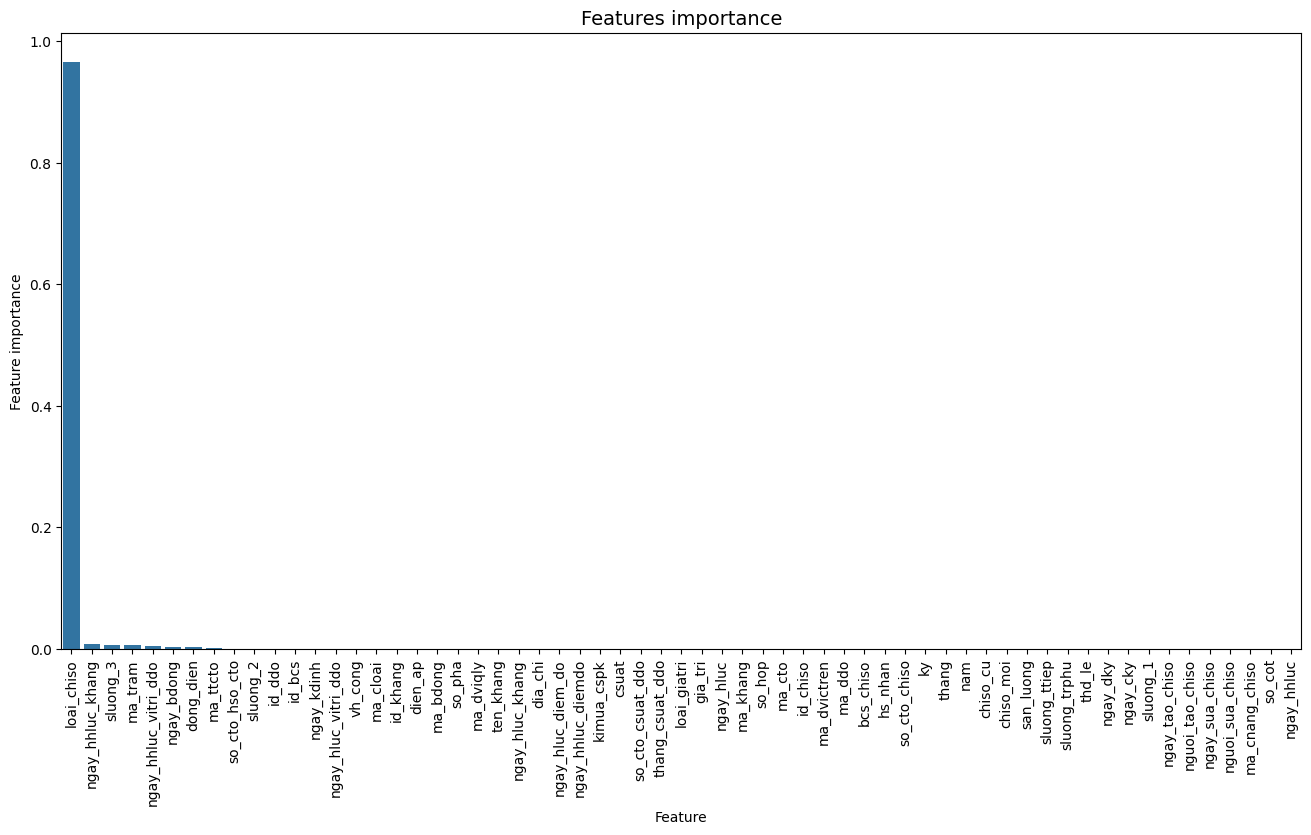

In [17]:
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()